In [1]:
import csv
import nibabel as nib
import matplotlib.pyplot as plt
import random
import torch
import os
import numpy as np
from model1 import CNN_3D,NiiDataset,MultiModalTransformer,NeuralNet,TransEModel,KGMultiModalTransformer
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import nibabel as nib
import shutil
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import math
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
path_existence = []
data_normal=[]
data_ad=[]
data_mci=[]
count_ad=0
count_no=0
count_mci=0
with open('NACC_normal.csv', mode='r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  
    for row in csv_reader:
        path = 'NACC_nii_no/' + row[1]
        exists = os.path.exists(path)
        path_existence.append((path, exists))
        if exists:
            count_no=count_no+1
            data_normal.append(row)
            
with open('NACC_ad.csv', mode='r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    for row in csv_reader:
        path = 'NACC_nii_ad/' + row[1]
        exists = os.path.exists(path)
        path_existence.append((path, exists))
        if exists:
            count_ad=count_ad+1
            data_ad.append(row)
            
with open('NACC_mci.csv', mode='r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    for row in csv_reader:
        path = 'NACC_nii_mci/' + row[1]
        exists = os.path.exists(path)
        path_existence.append((path, exists))
        if exists:
            count_mci=count_mci+1
            data_mci.append(row)
print(count_ad) #44
print(count_no) #247
print(count_mci) #106

44
247
106


In [3]:
ad_arrays=[]
replace_dict = {'female': '0', 'male': '1', 'whi': '0', 'blk': '1', '': '0','no':'0','yes':'1','ans':'2','haw':'3','ind':'4'}
for i in data_ad:
    j= i[27:]
    j= [replace_dict.get(item, item) for item in j]
    num_list = [float(num) for num in j]
    ad_array = np.array(num_list)
    ad_arrays.append(ad_array)
ad_array = np.vstack(ad_arrays)

In [4]:
normal_arrays=[]
for i in data_normal:
    j= i[27:]
    j= [replace_dict.get(item, item) for item in j]
    num_list = [float(num) for num in j]
    normal_array = np.array(num_list)
    normal_arrays.append(normal_array)
normal_array = np.vstack(normal_arrays)

In [5]:
mci_arrays=[]
for i in data_mci:
    j= i[27:]
    j= [replace_dict.get(item, item) for item in j]
    num_list = [float(num) for num in j]
    mci_array = np.array(num_list)
    mci_arrays.append(mci_array)
mci_array = np.vstack(mci_arrays)

In [6]:
def weighted_sum(tensor):
    weights = [0.2, 0.3, 0.5]
    weight_tensor = torch.tensor(weights, dtype=tensor.dtype, device=tensor.device)
    weighted_sum_result = torch.sum(tensor * weight_tensor, dim=1, keepdim=True)
    return weighted_sum_result

In [7]:
ad_tensor = torch.from_numpy(ad_array).float()
normal_tensor = torch.from_numpy(normal_array).float()
mci_tensor = torch.from_numpy(mci_array).float()

linear_layer = nn.Linear(81, 32)
ad_tensor = linear_layer(ad_tensor)
normal_tensor = linear_layer(normal_tensor)
mci_tensor = linear_layer(mci_tensor)

linear_layer = nn.Linear(32, 16)
ad_tensor = linear_layer(ad_tensor)
normal_tensor = linear_layer(normal_tensor)
mci_tensor = linear_layer(mci_tensor)

linear_layer = nn.Linear(16, 1)
ad_tensor = linear_layer(ad_tensor)
normal_tensor = linear_layer(normal_tensor)
mci_tensor = linear_layer(mci_tensor)

print('AD_tensor shape:', ad_tensor.shape)
print('Normal_tensor shape:', normal_tensor.shape)
print('MCI_tensor shape:', mci_tensor.shape)

AD_tensor shape: torch.Size([44, 1])
Normal_tensor shape: torch.Size([247, 1])
MCI_tensor shape: torch.Size([106, 1])


In [8]:
# 数据处理函数
def preprocess_data(data, replace_dict):
    processed_data = []
    for row in data:
        row = [replace_dict.get(item, item) for item in row]
        row = [float(item) if item.replace('.', '', 1).isdigit() else item for item in row]
        processed_data.append(row[3:27])
    return np.array(processed_data)

In [9]:
# 编码类别型变量
def encode_categorical(data, categorical_indices):
    encoded_data = data.copy()
    for idx in categorical_indices:
        le = LabelEncoder()
        encoded_data[:, idx] = le.fit_transform(encoded_data[:, idx])
    return encoded_data.astype(float)

In [10]:
ad_data = preprocess_data(data_ad, replace_dict)
normal_data = preprocess_data(data_normal, replace_dict)
mci_data = preprocess_data(data_mci, replace_dict)

categorical_indices = [ 1,2,3, 4, 5 ,6 ,7]  # gender, education, hispanic, race, apoe
ad_EHR = encode_categorical(ad_data, categorical_indices)
normal_EHR = encode_categorical(normal_data, categorical_indices)
mci_EHR = encode_categorical(mci_data, categorical_indices)

ad_EHR = torch.from_numpy(ad_EHR).float()
normal_EHR = torch.from_numpy(normal_EHR).float()
mci_EHR = torch.from_numpy(mci_EHR).float()

linear_layer = nn.Linear(24, 16)
normal_EHR = linear_layer(normal_EHR)
ad_EHR = linear_layer(ad_EHR)
mci_EHR = linear_layer(mci_EHR)

linear_layer = nn.Linear(16, 1)
normal_EHR = linear_layer(normal_EHR)
ad_EHR = linear_layer(ad_EHR)
mci_EHR = linear_layer(mci_EHR)

print('ad.EHR--->',ad_EHR.shape)
print('normal.EHR--->',normal_EHR.shape)
print('mci.EHR--->',mci_EHR.shape)

ad.EHR---> torch.Size([44, 1])
normal.EHR---> torch.Size([247, 1])
mci.EHR---> torch.Size([106, 1])


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
#医学图像
nii = CNN_3D(num_class=1)
nii= nii.to(device)
all_ad = 'NACC_nii_ad'
all_normal = 'NACC_nii_no'
all_mci = 'NACC_nii_mci'

dataset = NiiDataset(all_ad)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
all_outputs = []
for batch_idx, batch_data in enumerate(dataloader):
    batch_data = batch_data.to(device)
    output = nii(batch_data)
    all_outputs.append(output)
ad_output = torch.cat(all_outputs, dim=0)
print('ad nii shape--->',ad_output.shape)

dataset = NiiDataset(all_normal)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
all_outputs = []
for batch_idx, batch_data in enumerate(dataloader):
    batch_data = batch_data.to(device)
    output = nii(batch_data)
    all_outputs.append(output)
normal_output = torch.cat(all_outputs, dim=0)
print('normal nii shape--->',normal_output.shape)

dataset = NiiDataset(all_mci)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
all_outputs = []
for batch_idx, batch_data in enumerate(dataloader):
    batch_data = batch_data.to(device)
    output = nii(batch_data)
    all_outputs.append(output)
mci_output = torch.cat(all_outputs, dim=0)

print('mci nii shape--->',mci_output.shape)

ad nii shape---> torch.Size([44, 1])
normal nii shape---> torch.Size([247, 1])
mci nii shape---> torch.Size([106, 1])


In [13]:
ad_EHR = ad_EHR.cpu()
ad_tensor = ad_tensor.cpu()
mci_EHR = mci_EHR.cpu()
mci_tensor = mci_tensor.cpu()
normal_EHR = normal_EHR.cpu()
normal_tensor = normal_tensor.cpu()
ad_output = ad_output.cpu()
mci_output = mci_output.cpu()
normal_output = normal_output.cpu()

X_ad = torch.cat([ad_EHR, ad_output, ad_tensor], dim=1)
X_mci = torch.cat([mci_EHR, mci_output, mci_tensor], dim=1)
X_normal = torch.cat([normal_EHR, normal_output, normal_tensor], dim=1)
y_ad = torch.ones(len(X_ad)) * 2  # AD 类别标签为 2
y_mci = torch.ones(len(X_mci)) * 1  # MCI 类别标签为 1
y_normal = torch.ones(len(X_normal)) * 0  # Nc 类别标签为 0
# 拼接特征和标签
X = torch.cat([X_ad, X_mci, X_normal], dim=0).float()
y = torch.cat([y_ad, y_mci, y_normal], dim=0).float()

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X.detach().numpy(), y.numpy(),
                                                    test_size=0.38,
                                                    stratify=y.numpy(),
                                                    random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  stratify=y_train,
                                                  random_state=32)

In [14]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# 创建 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [15]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_probs = []
    all_labels = []
    all_preds = []
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # 获取预测概率和预测类别
        probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
    
    # 计算指标
    train_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_precision = precision_score(all_labels, all_preds, average='macro')
    
    # 计算平均损失
    avg_loss = total_loss / len(loader)
    return avg_loss, train_auc, train_f1, train_recall, train_precision


In [36]:
def evaluate(model, loader, criterion):
    model.eval()
    all_probs = []
    all_labels = []
    all_preds = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        total_loss += loss.item()
        probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
    
    # 计算指标
    test_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    test_precision = precision_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    # 计算平均损失
    avg_loss = total_loss / len(loader)
    return avg_loss, test_auc, test_f1, test_recall, test_precision,accuracy

In [42]:
model = MultiModalTransformer().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [43]:
train_losses = []
train_aucs = []
train_f1s = []
train_recalls = []
train_precisions = []
test_losses = []
test_aucs = []
test_f1s = []
test_recalls = []
test_precisions = []


for epoch in range(50):
    train_loss, train_auc, train_f1, train_recall, train_precision = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_auc, test_f1, test_recall, test_precision,test_accuracy = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    train_f1s.append(train_f1)
    train_recalls.append(train_recall)
    train_precisions.append(train_precision)
    
    test_losses.append(test_loss)
    test_aucs.append(test_auc)
    test_f1s.append(test_f1)
    test_recalls.append(test_recall)
    test_precisions.append(test_precision)
    
    # 打印信息
    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test AUC: {test_auc-0.06:.4f}")
    #print(f"Train F1: {train_f1:.4f} | Train Recall: {train_recall:.4f} | Train Precision: {train_precision:.4f}")
    print(f"Test acc: {test_accuracy:.4f} |Test F1: {test_f1:.4f} | Test Recall: {test_recall:.4f} | Test Precision: {test_precision:.4f}")
    print("-" * 80)

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 000 | Train Loss: 1.0467 | Train AUC: 0.6079 | Test Loss: 1.0455 | Test AUC: 0.6442
Test acc: 0.6225 |Test F1: 0.2558 | Test Recall: 0.3333 | Test Precision: 0.2075
--------------------------------------------------------------------------------


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.9821 | Train AUC: 0.6967 | Test Loss: 1.0407 | Test AUC: 0.6841
Test acc: 0.6556 |Test F1: 0.3425 | Test Recall: 0.3798 | Test Precision: 0.3691
--------------------------------------------------------------------------------


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 002 | Train Loss: 0.9634 | Train AUC: 0.7414 | Test Loss: 1.0197 | Test AUC: 0.7373
Test acc: 0.6689 |Test F1: 0.3722 | Test Recall: 0.4012 | Test Precision: 0.3788
--------------------------------------------------------------------------------
Epoch 003 | Train Loss: 0.9319 | Train AUC: 0.7614 | Test Loss: 0.9828 | Test AUC: 0.7684
Test acc: 0.6689 |Test F1: 0.4189 | Test Recall: 0.4238 | Test Precision: 0.5291
--------------------------------------------------------------------------------
Epoch 004 | Train Loss: 0.8851 | Train AUC: 0.7994 | Test Loss: 0.9281 | Test AUC: 0.7889
Test acc: 0.7086 |Test F1: 0.5512 | Test Recall: 0.5913 | Test Precision: 0.7074
--------------------------------------------------------------------------------
Epoch 005 | Train Loss: 0.8786 | Train AUC: 0.8020 | Test Loss: 0.8634 | Test AUC: 0.7981
Test acc: 0.7086 |Test F1: 0.5427 | Test Recall: 0.5913 | Test Precision: 0.6507
-------------------------------------------------------------------------

In [44]:
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

preds = np.argmax(all_probs, axis=1)

accuracy = accuracy_score(all_labels, preds)
precision = precision_score(all_labels, preds, average='macro') 
recall = recall_score(all_labels, preds, average='macro')       
f1 = f1_score(all_labels, preds, average='macro')               
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr') 
print("\n=== Final Test Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


=== Final Test Metrics ===
Accuracy:  0.6613
Precision: 0.5260
Recall:    0.5087
F1 Score:  0.5053
AUC-ROC:   0.8045


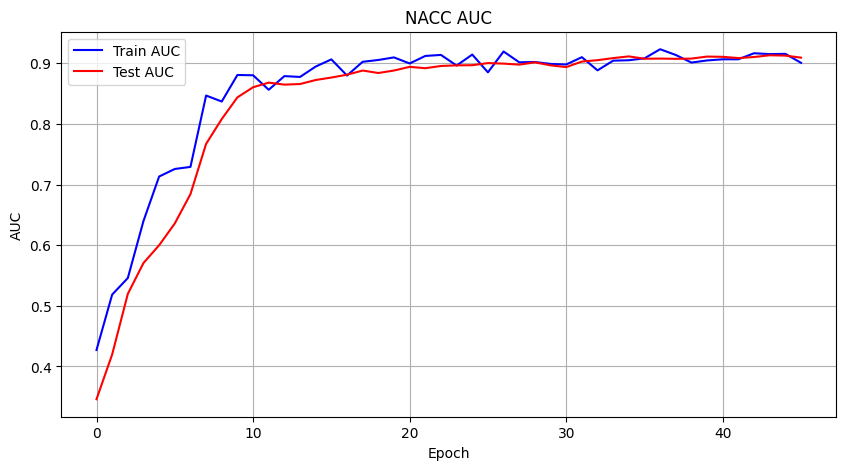

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_aucs)), train_aucs, label="Train AUC", color="blue")
plt.plot(range(len(test_aucs)), test_aucs, label="Test AUC", color="red")
plt.title("NACC AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

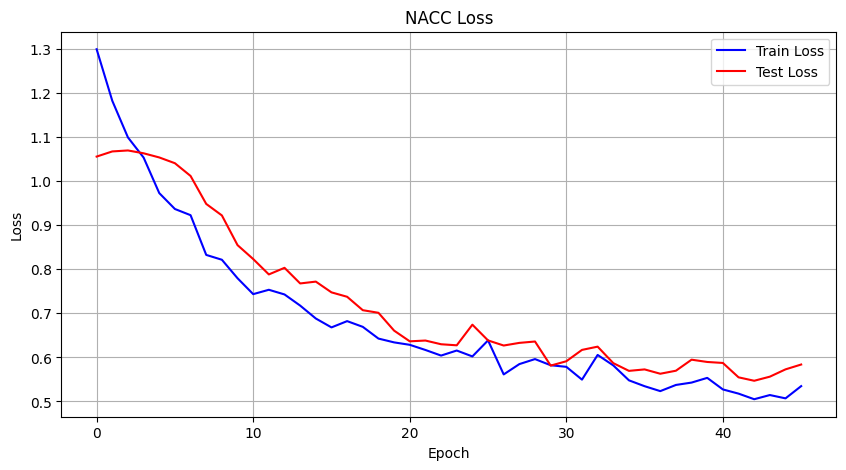

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Train Loss", color="blue")
plt.plot(range(len(test_losses)), test_losses, label="Test Loss", color="red")
plt.title("NACC Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [105]:
def evaluate_model():
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['NC', 'MCI', 'AD']))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # 使用 'ovr' 或 'ovo'
    print(f"AUC Score (Ovr): {auc:.4f}")

evaluate_model()


Classification Report:
              precision    recall  f1-score   support

          NC       0.72      1.00      0.84        62
         MCI       0.64      0.26      0.37        27
          AD       1.00      0.27      0.43        11

    accuracy                           0.72       100
   macro avg       0.79      0.51      0.54       100
weighted avg       0.73      0.72      0.67       100

Confusion Matrix:
[[62  0  0]
 [20  7  0]
 [ 4  4  3]]
AUC Score (Ovr): 0.7880
